In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer

In [ ]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 20 + np.random.randn(n_samples) * 2,
    'x2': 10 + np.random.randn(n_samples) * 2,
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = 2 * np.cos(df['x1']) + 3 * np.sin(df['x2']) + \
    np.random.randn(n_samples) * 2 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10
        
# np.sin(df['x1']) * np.cos(df['x2']) * 10 + \

x1_trans = FlatRampTransformer(
    knots = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
    pd.get_dummies(df['x3'], prefix='x3') * 1
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist()
                        + [ 'x3_' + str(cat) for cat in df['x3'].cat.categories.tolist() ])

In [3]:
df['x1_bins'] = pd.cut( df['x1'], bins=x1_trans.get_bins_and_labels()[0], labels=x1_trans.get_bins_and_labels()[1] )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_trans.get_bins_and_labels()[0], labels=x2_trans.get_bins_and_labels()[1] )

In [4]:
train_df.head()

,x1_bias,x1_le_15,x1_15_16,x1_16_17,x1_17_18,x1_18_19,x1_19_20,x1_20_21,x1_21_22,x1_22_23,...,x2_9_10,x2_10_11,x2_11_12,x2_12_13,x2_13_14,x2_14_15,x2_gt_15,x3_0,x3_1,x3_2
0,1.0,15.0,16.0,17.0,18.0,19.0,20.000000,20.993428,21.000000,22.0,...,10.000000,11.0,12.000000,12.061189,13.0,14.0,15.0,0.0,1.0,0.0
1,1.0,15.0,16.0,17.0,18.0,19.0,19.723471,20.000000,21.000000,22.0,...,9.000000,10.0,11.000000,12.000000,13.0,14.0,15.0,0.0,0.0,1.0
2,1.0,15.0,16.0,17.0,18.0,19.0,20.000000,21.000000,21.295377,22.0,...,10.000000,11.0,11.150874,12.000000,13.0,14.0,15.0,0.0,0.0,1.0
3,1.0,15.0,16.0,17.0,18.0,19.0,20.000000,21.000000,22.000000,23.0,...,9.000000,10.0,11.000000,12.000000,13.0,14.0,15.0,0.0,0.0,1.0
4,1.0,15.0,16.0,17.0,18.0,19.0,19.531693,20.000000,21.000000,22.0,...,9.345194,10.0,11.000000,12.000000,13.0,14.0,15.0,0.0,1.0,0.0


In [5]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),
                  'x3': [ 'x3_' + str(cat) for cat in df['x3'].cat.categories.tolist() ]}

## Piecewise Log Product Model

In [6]:
from quantbullet.optimizer.piecewise_product import PiecewiseProductModel

ppm = PiecewiseProductModel( xtol=1e-12, gtol=1e-12, ftol=1e-12 )

In [7]:
ppm.fit( X=train_df, y=df['y'], feature_groups=feature_groups, verbose=2 )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2503e+13                                    4.25e+13    
       1              2         2.0104e+13      2.24e+13       5.39e+00       1.65e+13    
       2              3         9.6286e+11      1.91e+13       5.39e+00       1.55e+12    
       3              5         7.7823e+10      8.85e+11       2.69e+00       1.58e+11    
       4              7         5.1194e+09      7.27e+10       1.35e+00       2.07e+10    
       5              8         5.5168e+08      4.57e+09       2.69e+00       1.80e+09    
       6             10         1.3053e+08      4.21e+08       1.35e+00       5.67e+08    
       7             11         6.5141e+07      6.54e+07       2.69e+00       5.68e+08    
       8             13         2.2004e+06      6.29e+07       6.73e-01       7.90e+07    
       9             15         7.0568e+05      1.49e+06       3.37e-01       3.53e+07    

In [8]:
df['model_predict'] = ppm.predict(train_df, feature_groups=feature_groups)

In [9]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df['y'], df['model_predict'])
print(f'Mean Squared Error: {mse:.4f}')

mse_avg = mean_squared_error(df['y'], np.full_like(df['y'], df['y'].mean()))
print(f'Mean Squared Error (Average Prediction): {mse_avg:.4f}')

Mean Squared Error: 4.3616
Mean Squared Error (Average Prediction): 11.4100


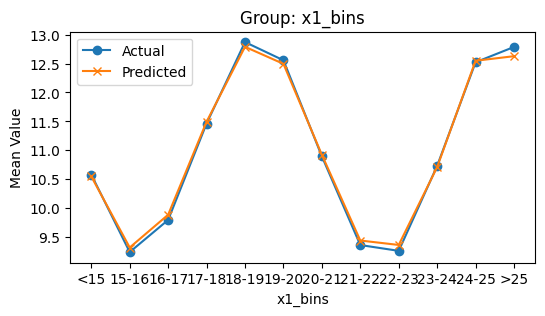

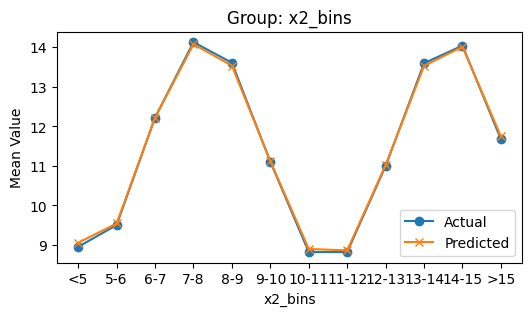

In [10]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(6, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Alternating Optimization

In [11]:
def group_feature_columns(columns):
    """
    Group feature column names by their root prefix before the first underscore.

    Parameters
    ----------
    columns : list-like
        Iterable of column names (e.g., DataFrame.columns).

    Returns
    -------
    dict
        { root_name : [list of full column names in original order] }
    """
    groups = {}
    for col in columns:
        # Split at first underscore
        root = col.split("_", 1)[0] if "_" in col else col
        groups.setdefault(root, []).append(col)
    return groups


In [12]:
feature_groups = group_feature_columns(train_df.columns)
n_features = train_df.shape[1]
n_obs = train_df.shape[0]
y = df['y'].values

In [13]:
feature_blocks = { key: train_df[feature_groups[key]].values for key in feature_groups }
init_params_blocks = {key: np.ones(len(feature_groups[key]), dtype=float) for key in feature_groups}

def forward(params_blocks, X_blocks):
    if len(params_blocks) != len(X_blocks):
        raise ValueError("Number of parameter blocks must match number of feature blocks.")
    
    result = np.ones(n_obs, dtype=float)
    for key in params_blocks:
        if key not in X_blocks:
            raise ValueError(f"Feature block '{key}' not found in input blocks.")
        result *= np.dot(X_blocks[key], params_blocks[key])

    return result

In [14]:
n_iterations = 10
curr_params_blocks = init_params_blocks.copy()

for i in range(n_iterations):
    print(f"Iteration {i+1}/{n_iterations}")
    for feature_group in feature_groups:
        floating_feature_group_params = curr_params_blocks[feature_group]
        floating_feature_group_data = feature_blocks[feature_group]

        fixed_params_blocks = { key: curr_params_blocks[key] for key in feature_groups if key != feature_group }
        fixed_X_blocks = { key: feature_blocks[key] for key in feature_groups if key != feature_group }
        fixed_predictions = forward(fixed_params_blocks, fixed_X_blocks)
        residuals = y / fixed_predictions

        # fit a OLS model to the residuals using matrix operations
        floating_feature_group_params = np.linalg.lstsq(floating_feature_group_data, residuals, rcond=None)[0]
        curr_params_blocks[feature_group] = floating_feature_group_params
    print(f"Updated parameters: {curr_params_blocks}")
    predictions = forward(curr_params_blocks, feature_blocks)
    mse = mean_squared_error(y, predictions)
    print(f"Mean Squared Error: {mse:.4f}")


Iteration 1/10
Updated parameters: {'x1': array([-0.16213745, -0.01364511, -0.00368621,  0.01147184,  0.01704623,
        0.00572017, -0.00994412, -0.01789435, -0.00729093,  0.00649161,
        0.01933411,  0.01146831, -0.00954787]), 'x2': array([134.91915929, -16.4506097 ,  28.12480642,  33.24286055,
        11.46339913, -20.4465851 , -34.27069419, -16.81970671,
        16.71789361,  34.45129743,  20.13349994, -13.70179121,
       -27.60798037]), 'x3': array([0.8814954 , 0.97564658, 1.07152504])}
Mean Squared Error: 4.3810
Iteration 2/10
Updated parameters: {'x1': array([-0.19482555, -0.01294754, -0.00401518,  0.01218041,  0.01767941,
        0.00632326, -0.01053658, -0.01838059, -0.008042  ,  0.00765058,
        0.01964848,  0.01045991, -0.00867979]), 'x2': array([124.78456638, -16.31443911,  27.62321064,  33.8264743 ,
        11.82338208, -20.96931679, -34.46048939, -16.87191743,
        16.7261332 ,  34.62244133,  20.40716058, -13.38806764,
       -27.44753539]), 'x3': array([0.881

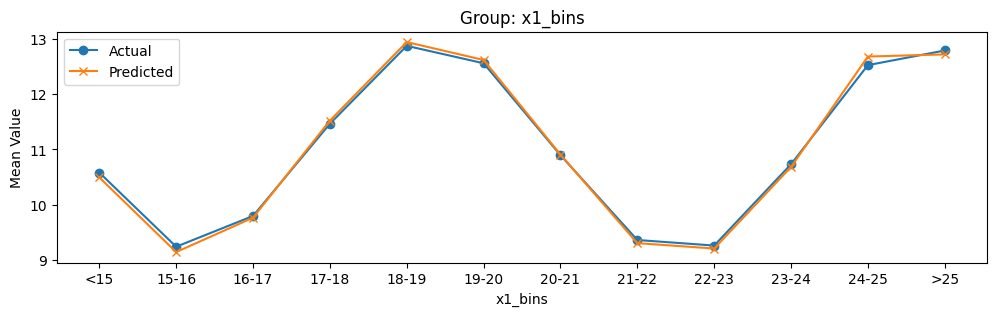

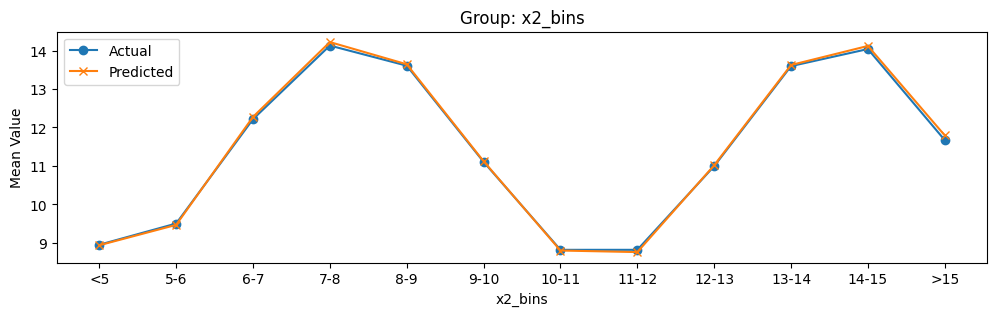

In [20]:
df['alternating_ols_predict'] = forward(curr_params_blocks, feature_blocks)
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(12, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'alternating_ols_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['alternating_ols_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [94]:
for k, v in ppm.coef_dict()['x1'].items():
    print (k, v / 4.53)

x1_bias 1.0018044456267257
x1_le_15 0.06539213363562833
x1_15_16 0.021106426285424217
x1_16_17 -0.06298901879751742
x1_17_18 -0.0902592027166517
x1_18_19 -0.032245764910090416
x1_19_20 0.05356233099413977
x1_20_21 0.09540797677425637
x1_21_22 0.041326229977938056
x1_22_23 -0.04076326340417393
x1_23_24 -0.09836023288369222
x1_24_25 -0.0575565235593468
x1_gt_25 0.045160889034336335


In [87]:
curr_params_blocks['x1']

array([-0.1951685 , -0.01294541, -0.00401638,  0.01218801,  0.01768156,
        0.00632977, -0.010541  , -0.01838387, -0.00805102,  0.00766022,
        0.01965059,  0.01044685, -0.00866222])

In [88]:
curr_params_blocks['x2']

array([124.72649368, -16.30879737,  27.61374595,  33.8162087 ,
        11.81997819, -20.96317375, -34.44947215, -16.86660935,
        16.72076698,  34.61133252,  20.40064004, -13.38273517,
       -27.43850796])

In [81]:
test_x1 = np.arange(12, 27 + 0.1, 0.1)

test_x1_trans = x1_trans.transform(test_x1.reshape(-1, 1))

In [85]:
test_x1_values = test_x1_trans @ curr_params_blocks['x1'].reshape(-1, 1)

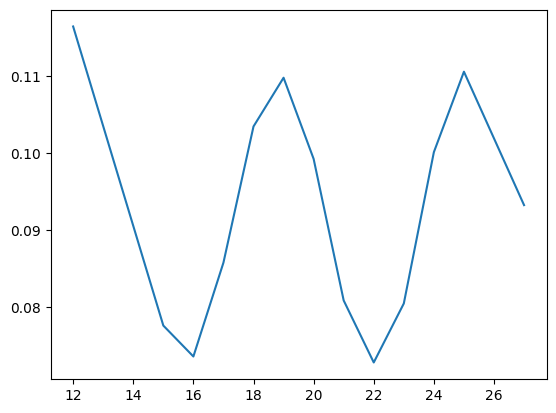

In [86]:
plt.plot(test_x1, test_x1_values, label='Transformed x1 Values')